# Exploring Store Competition with Networks

In [39]:
# Packages
from icecream import ic 
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import nxviz as nv 

In [40]:
# Help Functions

def extract_node_type(G: nx.Graph, node_type: str):
    # Extract a particular type of node from a graph
    nodeset = [n for n, d in G.nodes(data=True) if d["node_type"] == node_type]
    if len(nodeset) == 0:
        raise Exception(f"No nodes of node_type {node_type} exist!")
    return nodeset

## Part I: Introduction to Concepts and Application

#### Load data
Below we read the example data and transform it into nodes (with node_type customers/ shops), edges; We also add purchase_count as metadata that can be used for weights or further calculation.

Aside from the customer ID, shop ID and purchase count we also compute a metric called 'proportional_weight'. It represents the fraction of purchases a customer generated in a given shop. It is an indication of how exceptional the purchase in this shop was (i.e. 1 = 100% of purchases happened in this shop)    

In [ ]:
# Load the data from the CSV
df = pd.read_csv('D:/competition_network/images/network_example.csv')

# Create an empty bipartite graph
B = nx.Graph()

# Loop through each row and calculate both the proportional weight and the absolute weight
# Group by customer to calculate the total number of purchases per customer
total_purchases_per_customer = df.groupby('customer_ID')['purchase_count'].sum()

for _, row in df.iterrows():
    customer = row['customer_ID']
    shop = row['shop_ID']
    absolute_weight = row['purchase_count']
    
    # Add "purchase_count" as edge weight 
    B.add_edge(customer, shop, absolute_weight=absolute_weight)

    # Add node type attributes
    B.nodes[customer]['node_type'] = 'customer'
    B.nodes[shop]['node_type'] = 'shop'


print("Bipartite graph created with", len(B.nodes), "nodes and", len(B.edges), "edges.")


Bipartite graph created with 27 nodes and 37 edges.


#### Visualize the Graph: Parellel & Hairball

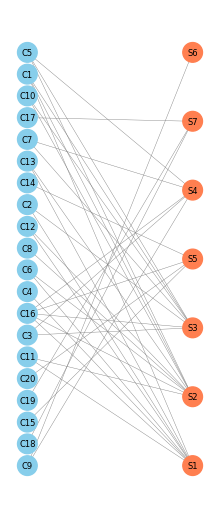

In [ ]:
colors = ['skyblue' if B.nodes[node].get('node_type') == 'customer' else 'coral' for node in B.nodes]

top_nodes = {n for n, d in B.nodes(data=True) if d['node_type'] == 'customer'}  # Group 1
pos = nx.bipartite_layout(B, top_nodes)

plt.figure(figsize=(2, 5))
nx.draw(
    B, 
    pos, 
    with_labels=True, 
    node_color=colors, 
    node_size=200, 
    font_size=6, 
    edge_color='gray', 
    width=0.3  # Thin edges
)


# plt.title("Undirected Bipartite Graph (Customer nodes blue | Shop nodes orange)")
# output_path = r"D:/competition_network/images/bipartite_graph.png"
# plt.savefig(output_path, format='png', dpi=150, bbox_inches='tight')

plt.show()
plt.close()

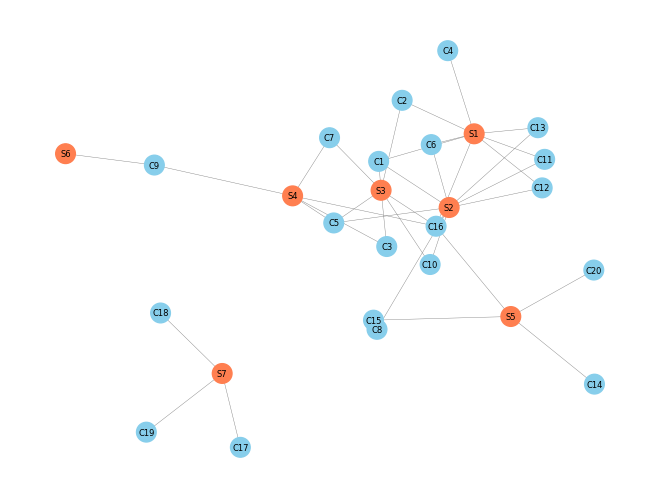

In [ ]:
# Draw the graph
pos = nx.spring_layout(B, k=0.5, scale=1.5)  # Adjust 'k' for repulsion strength, 'scale' for overall size
nx.draw(B, 
    pos,
    with_labels=True, 
    node_color=colors, 
    node_size=200, 
    font_size=6,
    edge_color='gray', 
    width=0.3)

# plt.title("Hairball (Customer nodes blue | Shop nodes orange)")
# output_path = r"D:/competition_network/images/hairball.png"
# plt.savefig(output_path, format='png', dpi=150, bbox_inches='tight')

plt.show()
plt.close()

#### Projection

With ```bipartite.projected_graph(B, shop_nodes)``` function lets you create a projected graph. It makes a new graph where each node is a shop. It also makes edges between pairs of shop nodes that have at least one customer in common. Since customer nodes are turned into edges, the resulting graph only has shop nodes. 

In [44]:
# extract nodes from a particular partition
customer_nodes = extract_node_type(B, "customer")
shop_nodes = extract_node_type(B, "shop")

# compute the projection (projecting on shops)
shop_graph = bipartite.projected_graph(B, shop_nodes)

A single shared customer is enough to create an edge between two shops. However, if we would ignore the number of customers between shops, we would lose crucial information. That is, two shops that share 10 customers provide more evidence for competition than shops that have only a single customer in common. Fortunately, this information can be preserved using a weighted projection, where the number of shared customers enters the graph as an edge weight. This can be achieved with ```bipartite.weighted_projected_graph(B, shop_nodes)```.

In [ ]:
weighted_shop_graph = bipartite.weighted_projected_graph(B, shop_nodes)

#### Visualize Adjacency Matrix and Circos Plot

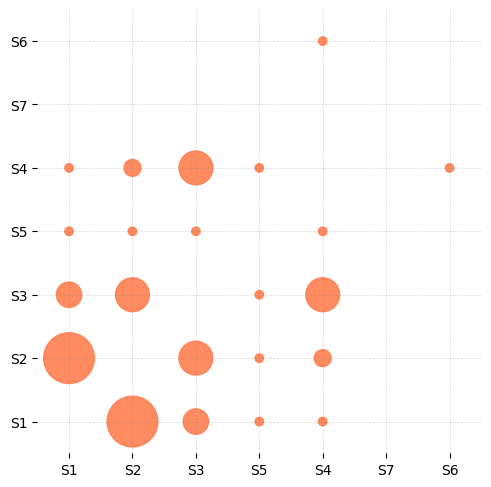

In [ ]:
# Get the adjacency matrix of the weighted projected graph
adj_matrix = nx.to_numpy_array(weighted_shop_graph, weight='weight')
nodes = list(weighted_shop_graph.nodes())

fig, ax = plt.subplots(figsize=(5, 5))

# Plot each cell as a circle
for i in range(adj_matrix.shape[0]):
    for j in range(adj_matrix.shape[1]):
        weight = adj_matrix[i, j]
        if weight > 0:  # Only plot for non-zero weights
            circle = plt.Circle((j, i), radius=weight / np.max(adj_matrix) * 0.4, color='coral', alpha=0.9)
            ax.add_artist(circle)


ax.set_xticks(range(len(nodes)))
ax.set_yticks(range(len(nodes)))
ax.set_xticklabels(nodes)
ax.set_yticklabels(nodes)

ax.set_xlim(-0.5, len(nodes) - 0.5)
ax.set_ylim(-0.5, len(nodes) - 0.5)
ax.set_aspect('equal')
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.3)

for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()

# plt.title("Adjacency Matrix with Circles Representing Weights")
# output_path = r"D:/competition_network/images/circle_adjacency_matrix.png"
# plt.savefig(output_path, format='png', dpi=150)
plt.show()

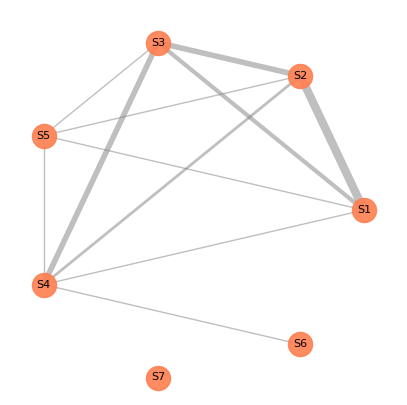

In [ ]:
# Get positions for nodes in a circular layout
pos = nx.circular_layout(weighted_shop_graph)
# Get edge weights
weights = [weighted_shop_graph[u][v]['weight'] for u, v in weighted_shop_graph.edges()]


plt.figure(figsize=(5, 5))
ax = plt.gca()

nx.draw_networkx_nodes(weighted_shop_graph, pos, node_size=300, node_color='coral', alpha=0.9)
nx.draw_networkx_edges(weighted_shop_graph, pos, width=weights, edge_color='gray', alpha=0.5) 
nx.draw_networkx_labels(weighted_shop_graph, pos, font_size=8, font_color='black')
plt.axis('off')

# plt.title("Circos Plot of Weighted Projected Graph")
# output_path = r"D:/competition_network/images/circos_weighted_projection.png"
# plt.savefig(output_path, format='png', dpi=150)

plt.show()

## Part I: Introduction to Concepts and Application

### Key Metrics
Network analytics offers numerous tools and metrics. To achieve our goal of quantifying competitive intensity, we need to think about the observable patterns competition might produce in a graph. Here is a list of the most obvious characteristics a highly contested shop 'X' might exhibit:

- Low share of wallet: A low average share of wallet as result of having few unshared customers, and shared customers that buy mostly at competitors.
- Few loyal customers: A high fraction of shared customers relative to its total customer base.
- Intense direct competition: X has many direct competitors.
- Intense indirect competition: X is member of of densely connected competitor cluster, increasing localized competitive pressure.
- Submission: Important competitors have a high average share of wallet and much larger customer base, relative to X's own customer base.

This list is guided by intuition and is by no means exhaustive or grounded in theory. It provides a starting point for building and selecting metrics that we can then test against our data.

### Low Share of Wallet

We define share of wallet as the proportion of purchases made by customer C in shop S / by all purchases of customer C. Thus, if share of wallet exceeds 0.5, the customer made the majority of purchases in shop S. If we average the proportion for all customers of a shop, it tells us something about the loyality of the client base i.e. values approach 1 represent very high loyality. 

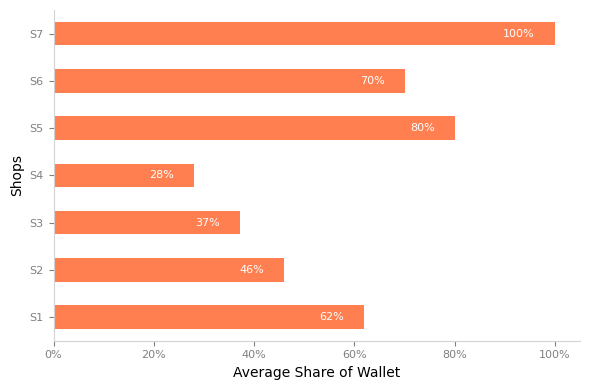

In [ ]:
# Add share_of_wallet to each row in the DataFrame
total_purchases_per_customer = df.groupby('customer_ID')['purchase_count'].sum()
df['share_of_wallet'] = df['purchase_count'] / df['customer_ID'].map(total_purchases_per_customer)


# Assign share_of_wallet as an edge attribute in the bipartite graph
for _, row in df.iterrows():
    customer = row['customer_ID']
    shop = row['shop_ID']
    share_of_wallet = row['share_of_wallet']
    if B.has_edge(customer, shop):
        B[customer][shop]['share_of_wallet'] = share_of_wallet


 
# Define a function that calculates the AVG share of wallet
def get_avg_share_of_wallet(G: nx.Graph, node_set: list, weight_col: str):

    avg_share_of_wallet = {}

    for n in node_set:
        sum_of_weights = 0
        count_of_edges = 0
        
        for n1, n2, d in G.edges(n, data=True):  
            sum_of_weights += d[weight_col]
            count_of_edges += 1
        
        average_weight = sum_of_weights / count_of_edges if count_of_edges > 0 else 0
        avg_share_of_wallet[n] = average_weight

    return pd.Series(avg_share_of_wallet, name= "AVG_SHARE_OF_WALLET").sort_index()

# Create a series with AVG share of wallet per shop 
avg_share_of_wallet = get_avg_share_of_wallet(B, shop_nodes, 'share_of_wallet')



# Create bar chart
plt.figure(figsize=(6, 4))
ax = avg_share_of_wallet.plot(kind='barh', color='coral', edgecolor=None)

plt.xlabel("Average Share of Wallet")
plt.ylabel("Shops")

# Bar labels
for index, value in enumerate(avg_share_of_wallet):
    ax.text(value - 0.04, index, f"{value:.0%}", 
            color='white', va='center', ha='right', fontsize=8)
    

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('lightgray')
ax.spines['bottom'].set_color('lightgray')

ax.tick_params(axis='both', colors='gray', labelsize=8)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0%}"))

plt.tight_layout()

# plt.title("Share of Wallet by Shop")
output_path = r"D:/competition_network/images/share_of_wallet.png"
plt.savefig(output_path, format='png', dpi=150)

plt.show()
plt.close()
